In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('bma-skewed-simulated.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9979,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9980,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9981,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9982,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            
        
    #print('')


In [9]:
pairs = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        #print(i, end=': ')
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9984/9984 [00:00<00:00, 10785.72it/s]


In [10]:
import numpy as np


In [11]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [12]:
for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)


 -> G @ 56 6
 -> A @ 56 6
G ->  @ 55 6
 -> C @ 56 7
T ->  @ 55 7
A ->  @ 56 7
 -> T @ 109 7
 -> T @ 56 8
 -> G @ 109 8
C ->  @ 56 8
T ->  @ 56 9
G ->  @ 56 9
 -> C @ 109 10
 -> A @ 109 19
A ->  @ 110 19
C ->  @ 110 28
 -> C @ 55 29
 -> G @ 55 29
T ->  @ 110 36
 -> A @ 55 36
 -> T @ 55 39
G ->  @ 110 40


In [13]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

print(pos_map['_T'])

[4, 6, 5, 3, 1, 4, 5, 5, 5, 3, 4, 3, 4, 4, 5, 7, 7, 5, 5, 6, 3, 8, 11, 9, 3, 7, 9, 9, 4, 2, 12, 8, 8, 8, 7, 3, 7, 10, 5, 7, 6, 5, 8, 9, 15, 8, 12, 10, 6, 8, 13, 14, 19, 30, 33, 193, 80, 33, 17, 16, 9, 6, 8, 4, 6, 17, 12, 7, 9, 13, 8, 12, 6, 9, 11, 14, 11, 8, 12, 7, 11, 10, 11, 9, 7, 10, 4, 10, 6, 9, 7, 2, 7, 5, 7, 5, 6, 9, 8, 6, 7, 9, 3, 10, 9, 6, 8, 10, 8, 56, 161]


In [14]:
import matplotlib.pyplot as plt

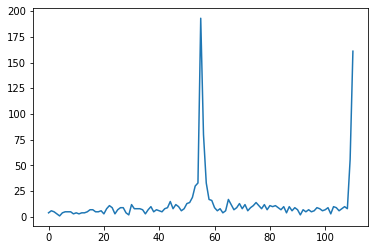

In [15]:
keys = ['G_', '_T', 'C_', '_G', '_A', '_TC']
for key in keys:
    plt.plot(range(strand_len + 1), pos_map[key])

In [16]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)